        socialNbFollowers  socialNbFollows  socialProductsLiked  \
count                1207             1207                 1207   
unique                 13               21                   93   
top                     4                8                    0   
freq                  207              896                  394   

        productsListed  productsWished  productsBought  civilityGenderId  \
count             1207            1207            1207              1207   
unique               6              61              26                 3   
top                  1               0               0                 2   
freq               499             728             862               881   

       civilityTitle  hasAnyApp  hasAndroidApp  ...  countryCode_vg  \
count           1207       1207           1207  ...          1207.0   
unique             3          2              2  ...             1.0   
top              mrs          1              0  ...             0.0   

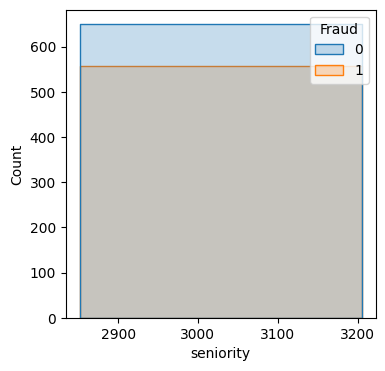

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
data = pd.read_csv("raw_data.csv")
# print(data.columns)
if 'identifierHash' in data.columns:
    data.drop('identifierHash', axis=1, inplace=True)

#data.drop(['identifierHash','type','country','language','hasAnyApp','civilityTitle','civilityGenderId','seniorityAsMonths','seniorityAsYears','countryCode','productsWished','productsBought','hasAndroidApp','hasIosApp'],axis=1,inplace=True)
# Initialize encoders
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse_output=False)
#print(data['gender'].unique())
converted = pd.get_dummies(data['gender'], drop_first=1)
data = pd.concat([data, converted], axis = 1)
data.drop('gender',axis = 1, inplace=True)
data.rename(columns={'M': 'Male'}, inplace=True)
#print(data['Male'].unique())
data = data.fillna(0)

# Check the data types of each column in the DataFrame
#print(data.dtypes)

# Identify numeric columns (int and float types)
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
boolean_columns = ['hasAnyApp', 'hasAndroidApp', 'hasIosApp', 'hasProfilePicture', 'Male']
# Handle non-numeric columns separately (e.g., keep them as they are, or convert them to category type)
# Example: Convert object-type columns to category type if necessary
object_columns = data.select_dtypes(include='object').columns
for col in object_columns:
    data[col] = data[col].astype('category')
# Convert boolean columns to integers
for col in boolean_columns:
    data[col] = data[col].astype(int)

# Convert only numeric columns to integer types
data[numeric_columns] = data[numeric_columns].astype(int)

categorical_columns = ['type', 'country', 'language', 'countryCode']
# Convert categorical columns using one-hot encoding
encoded_data = one_hot_encoder.fit_transform(data[categorical_columns])

# Create a DataFrame with one-hot encoded columns
encoded_df = pd.DataFrame(encoded_data, columns=one_hot_encoder.get_feature_names_out(categorical_columns))

# Combine the one-hot encoded columns with the original data, excluding the original categorical columns
data = pd.concat([data, encoded_df], axis=1).drop(categorical_columns, axis=1)

def zscore(array):
    thr = 3
    mean = np.mean(array)
    std = np.std(array)
    z_scores = (array - mean) / std
    return np.abs(z_scores) > thr


combined_condition = ~(zscore(data['socialNbFollows']) | zscore(data['socialNbFollowers']) | zscore(data['productsListed']) | zscore(data['productsSold']) | zscore(data['socialProductsLiked']))
data = data[combined_condition]
data.reset_index(drop=True, inplace=True)
#print(new_data.head())
#print(data.describe())


def pure_round(num):
    integer = int(num)
    fraction = num - float(integer)
    if fraction >= 0.5:
        integer += 1
    return integer

data = data[data['productsListed'] != 0]
for i in data.index:
    case_no = data.loc[i,'productsSold']
    pass_no = pure_round((case_no * data.loc[i,'productsPassRate']) / 100)
    fail_no = case_no - pass_no
    data.loc[i,'productsPassed'] = pass_no
    data.loc[i,'productsFailed'] = fail_no
    if case_no == 0:
        data.drop(i, axis=0, inplace=True)
 
data.drop(['productsPassRate','productsSold'], axis=1, inplace=True)

# Encodedict = {}
# for i in ['Male','hasProfilePicture']:
#     key = '_{}'.format(i)
#     le = LabelEncoder()
#     data[key] = le.fit_transform(list(data[i]))
#     Encodedict[key] = le.classes_

# data.drop(['Male','hasProfilePicture'], axis=1, inplace=True)

dfdict = {}
for j in data.index:
    x = data.loc[j,'productsPassed']
    y = data.loc[j,'productsFailed']
    if x != 0:
        data.loc[j,'Fraud'] = 0
        df = pd.DataFrame(data.loc[j,:]).transpose()
        ldf = pd.concat([df]*int(x), ignore_index=True)
    
    if y != 0:
        data.loc[j,'Fraud'] = 1
        df2 = pd.DataFrame(data.loc[j,:]).transpose()
        ldf2 = pd.concat([df2]*int(y), ignore_index=True)
    
    if x != 0 and y != 0:
        dfdict[j] = pd.concat([ldf, ldf2], ignore_index=True)
    elif x != 0:
        dfdict[j] = ldf
    else:
        dfdict[j] = ldf2

data_new = pd.concat(dfdict.values(), ignore_index=True)
data_new.drop(['productsPassed','productsFailed'], axis=1, inplace=True)
print(data_new.describe())


from sklearn.model_selection import train_test_split

# Assuming 'Fraud' is your target variable
X = data_new.drop('Fraud', axis=1)  # Features
y = data_new['Fraud']  # Target variable
# Step 1: Convert the 'Fraud' column to numeric values, coercing any non-numeric values to NaN
data_new['Fraud'] = pd.to_numeric(data_new['Fraud'], errors='coerce')

# Step 2: Convert the 'Fraud' column to int64
data_new['Fraud'] = data_new['Fraud'].astype('int64')
plt.figure(figsize=(4, 4))
#sns.countplot(x='productsListed', hue='Fraud', data=data_new, palette = 'inferno')
#sns.boxplot(x='productsListed', y='socialNbFollowers', hue='Fraud', data=data, palette = 'inferno')
sns.histplot(x = 'seniority', data = data_new, binwidth = 350, hue = 'Fraud', element = 'step')
# Splitting the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optionally, you can reset index for train and test sets
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
print(data_new.head())
# Ensure y_train contains only numeric values, and convert non-numeric values to NaN
y_train = pd.to_numeric(y_train, errors='coerce')

# Handle any missing values (NaN) as needed
# For example, you can drop rows with missing values or fill them with a default value:
y_train = y_train.dropna()  # Drop rows with NaN values

# Convert the series to integer type
y_train = y_train.astype(int)


X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')
y_test = y_test.astype(int)
X_test.fillna(X_test.mean(), inplace=True)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


In [76]:
import numpy as np

print(f"y_test data type: {y_test.dtype}")
print(f"y_pred data type: {y_pred.dtype}")

print(f"Unique values in y_test: {np.unique(y_test)}")
print(f"Unique values in y_pred: {np.unique(y_pred)}")


y_test data type: int64
y_pred data type: int64
Unique values in y_test: [0 1]
Unique values in y_pred: [0 1]


In [77]:

# Import necessary libraries and modules
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define the imputation strategy for numerical and categorical features
numeric_transformer = SimpleImputer(strategy='mean')  # Use mean imputation for numerical data
categorical_transformer = SimpleImputer(strategy='most_frequent')  # Use most frequent for categorical data

# Define which features are numerical and categorical
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Create a ColumnTransformer to handle different feature types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create a pipeline with the preprocessor and the GaussianNB classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', GaussianNB())
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Use the pipeline to predict on the test data
y_pred = pipeline.predict(X_test)

# Calculate accuracy and print the classification report
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy without PCA:", accuracy)
print(classification_report(y_test, y_pred))
# Step 1: Impute missing values
imputer = SimpleImputer(strategy='mean')  # Choose a strategy (mean, median, most_frequent)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Step 2: Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Step 3: Apply PCA
pca = PCA(n_components=0.93)  # Specify the desired variance to retain
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Step 4: Train and evaluate Gaussian Naive Bayes with PCA
gnb_pca = GaussianNB()
gnb_pca.fit(X_train_pca, y_train)
y_pred_pca = gnb_pca.predict(X_test_pca)

# Calculate accuracy and print classification report
accuracy_with_pca = accuracy_score(y_test, y_pred_pca)
print("Accuracy with PCA:", accuracy_with_pca)
print("Classification Report with PCA:")
print(classification_report(y_test, y_pred_pca))

Accuracy without PCA: 0.4380165289256198
              precision    recall  f1-score   support

           0       0.50      0.24      0.33       136
           1       0.41      0.69      0.52       106

    accuracy                           0.44       242
   macro avg       0.46      0.47      0.42       242
weighted avg       0.46      0.44      0.41       242

Accuracy with PCA: 0.5289256198347108
Classification Report with PCA:
              precision    recall  f1-score   support

           0       0.59      0.52      0.55       136
           1       0.47      0.54      0.50       106

    accuracy                           0.53       242
   macro avg       0.53      0.53      0.53       242
weighted avg       0.54      0.53      0.53       242



/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='mean'.
  warning

In [78]:
# Import necessary modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

# Handle missing values and categorical data with ColumnTransformer
numeric_features = X_train.columns.difference(['civilityTitle'])  # Update with your actual column names
categorical_features = ['civilityTitle']  # Update with your actual column names

numeric_transformer = SimpleImputer(strategy='mean')  # Use mean imputation for numeric data
categorical_transformer = SimpleImputer(strategy='most_frequent')  # Use most frequent for categorical data

# Create ColumnTransformer with both transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define a pipeline with the preprocessor and PCA
pipeline_pca = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=100)),
    ('clf', RandomForestClassifier(n_estimators=100))
])

# Train the pipeline with PCA on the training data
pipeline_pca.fit(X_train, y_train)

# Predict on the testing data using the pipeline
y_pred_pca = pipeline_pca.predict(X_test)

# Calculate accuracy and print classification report
accuracy_pca = accuracy_score(y_test, y_pred_pca)
report_pca = classification_report(y_test, y_pred_pca)

print("\nRandom Forest with PCA:")
print("Accuracy:", accuracy_pca)
print(report_pca)

# Define a second pipeline without PCA for comparison
pipeline_original = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100))
])

# Train the pipeline without PCA on the training data
pipeline_original.fit(X_train, y_train)

# Predict on the testing data using the pipeline
y_pred_original = pipeline_original.predict(X_test)

# Calculate accuracy and print classification report
accuracy_original = accuracy_score(y_test, y_pred_original)
report_original = classification_report(y_test, y_pred_original)

print("\nRandom Forest without PCA:")
print("Accuracy:", accuracy_original)
print(report_original)


/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(



Random Forest with PCA:
Accuracy: 0.7355371900826446
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       136
           1       0.72      0.65      0.68       106

    accuracy                           0.74       242
   macro avg       0.73      0.73      0.73       242
weighted avg       0.73      0.74      0.73       242


Random Forest without PCA:
Accuracy: 0.7355371900826446
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       136
           1       0.71      0.66      0.69       106

    accuracy                           0.74       242
   macro avg       0.73      0.73      0.73       242
weighted avg       0.73      0.74      0.73       242



/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

# Define parameters for Random Forest
n_estimators = 100  # Number of trees in the forest
max_depth = 10  # Maximum depth of each tree (you can experiment with this value)
min_samples_split = 4  # Minimum samples required to split a node
min_samples_leaf = 2  # Minimum samples required at a leaf node
max_features = 'sqrt'  # Number of features to consider for best split

# Create a pipeline with the preprocessor and Random Forest with regularization
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42  # Seed for reproducibility
    ))
])

# Train the pipeline on the training data
pipeline_rf.fit(X_train, y_train)

# Predict on the testing data using the pipeline
y_pred_rf = pipeline_rf.predict(X_test)

# Calculate accuracy and print classification report
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print("\nRandom Forest with regularization:")
print("Accuracy:", accuracy_rf)
print(report_rf)



Random Forest with regularization:
Accuracy: 0.640495867768595
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       136
           1       0.62      0.46      0.53       106

    accuracy                           0.64       242
   macro avg       0.64      0.62      0.62       242
weighted avg       0.64      0.64      0.63       242



/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# Define a pipeline with the preprocessor, scaler, PCA, and Logistic Regression
pipeline_pca_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.80)),  # Adjust n_components as needed
    ('clf', LogisticRegression(max_iter=1000))
])

# Train the pipeline with PCA on the training data
pipeline_pca_lr.fit(X_train, y_train)

# Predict on the testing data using the pipeline
y_pred_pca_lr = pipeline_pca_lr.predict(X_test)

# Calculate accuracy and print classification report
accuracy_pca_lr = accuracy_score(y_test, y_pred_pca_lr)
report_pca_lr = classification_report(y_test, y_pred_pca_lr)

print("\nLogistic Regression with PCA:")
print("Accuracy:", accuracy_pca_lr)
print(report_pca_lr)

# Define a second pipeline without PCA for comparison
pipeline_original_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

# Train the pipeline without PCA on the training data
pipeline_original_lr.fit(X_train, y_train)

# Predict on the testing data using the pipeline
y_pred_original_lr = pipeline_original_lr.predict(X_test)

# Calculate accuracy and print classification report
accuracy_original_lr = accuracy_score(y_test, y_pred_original_lr)
report_original_lr = classification_report(y_test, y_pred_original_lr)

print("\nLogistic Regression without PCA:")
print("Accuracy:", accuracy_original_lr)
print(report_original_lr)


/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(



Logistic Regression with PCA:
Accuracy: 0.5578512396694215
              precision    recall  f1-score   support

           0       0.59      0.68      0.63       136
           1       0.49      0.40      0.44       106

    accuracy                           0.56       242
   macro avg       0.54      0.54      0.54       242
weighted avg       0.55      0.56      0.55       242


Logistic Regression without PCA:
Accuracy: 0.5909090909090909
              precision    recall  f1-score   support

           0       0.61      0.73      0.67       136
           1       0.54      0.42      0.47       106

    accuracy                           0.59       242
   macro avg       0.58      0.57      0.57       242
weighted avg       0.58      0.59      0.58       242



/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Define the regularization type (penalty) and regularization strength (C)
# 'l1' for L1 regularization and 'l2' for L2 regularization
penalty_type = 'l2'  # Change to 'l1' if you want L1 regularization
C_value = 1.0  # Regularization strength; you can experiment with different values

# Define the logistic regression model with the appropriate solver for L1 regularization
solver_type = 'liblinear' if penalty_type == 'l1' else 'lbfgs'

# Create a pipeline without PCA, including preprocessing and logistic regression
pipeline_no_pca_lr = Pipeline([
    ('preprocessor', preprocessor),  # Column transformer for data preprocessing
    ('scaler', StandardScaler()),  # Standard scaling (optional but recommended)
    ('clf', LogisticRegression(
        penalty=penalty_type,
        C=C_value,
        solver=solver_type,
        max_iter=1000,
        random_state=42  # Seed for reproducibility
    ))
])

# Train the pipeline with logistic regression (no PCA) on the training data
pipeline_no_pca_lr.fit(X_train, y_train)

# Predict on the testing data using the pipeline
y_pred_no_pca_lr = pipeline_no_pca_lr.predict(X_test)

# Calculate accuracy and print classification report
accuracy_no_pca_lr = accuracy_score(y_test, y_pred_no_pca_lr)
report_no_pca_lr = classification_report(y_test, y_pred_no_pca_lr)

print("\nLogistic Regression without PCA but with regularization:")
print("Accuracy:", accuracy_no_pca_lr)
print(report_no_pca_lr)


/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(



Logistic Regression without PCA but with regularization:
Accuracy: 0.5909090909090909
              precision    recall  f1-score   support

           0       0.61      0.73      0.67       136
           1       0.54      0.42      0.47       106

    accuracy                           0.59       242
   macro avg       0.58      0.57      0.57       242
weighted avg       0.58      0.59      0.58       242



/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


In [124]:

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# Define a pipeline with the preprocessor, scaler, PCA, and Logistic Regression
pipeline_pca_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.80)),  # Adjust n_components as needed
    ('clf', LogisticRegression(max_iter=1000))
])

# Train the pipeline with PCA on the training data
pipeline_pca_lr.fit(X_train, y_train)

# Predict on the testing data using the pipeline
y_pred_pca_lr = pipeline_pca_lr.predict(X_test)

# Calculate accuracy and print classification report
accuracy_pca_lr = accuracy_score(y_test, y_pred_pca_lr)
report_pca_lr = classification_report(y_test, y_pred_pca_lr)

print("\nLogistic Regression with PCA:")
print("Accuracy:", accuracy_pca_lr)
print(report_pca_lr)
# Define the regularization type (penalty) and regularization strength (C)
# 'l1' for L1 regularization and 'l2' for L2 regularization
penalty_type = 'l2'  # Change to 'l2' if you want L2 regularization
C_value = 1.0  # Regularization strength; you can experiment with different values

# Define the logistic regression model with the appropriate solver for L1 regularization
solver_type = 'liblinear' if penalty_type == 'l1' else 'lbfgs'

# Create a pipeline with preprocessing, PCA, and logistic regression
pipeline_pca_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=100)),  # Adjust the number of components as needed
    ('clf', LogisticRegression(
        penalty=penalty_type,
        C=C_value,
        solver=solver_type,
        max_iter=1000,
        random_state=42  # Seed for reproducibility
    ))
])

# Train the pipeline with PCA and logistic regression on the training data
pipeline_pca_lr.fit(X_train, y_train)

# Predict on the testing data using the pipeline
y_pred_pca_lr = pipeline_pca_lr.predict(X_test)

# Calculate accuracy and print classification report
accuracy_pca_lr = accuracy_score(y_test, y_pred_pca_lr)
report_pca_lr = classification_report(y_test, y_pred_pca_lr)

print("\nLogistic Regression with PCA and regularization:")
print("Accuracy:", accuracy_pca_lr)
print(report_pca_lr)


/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(



Logistic Regression with PCA:
Accuracy: 0.5578512396694215
              precision    recall  f1-score   support

           0       0.59      0.68      0.63       136
           1       0.49      0.40      0.44       106

    accuracy                           0.56       242
   macro avg       0.54      0.54      0.54       242
weighted avg       0.55      0.56      0.55       242


Logistic Regression with PCA and regularization:
Accuracy: 0.5909090909090909
              precision    recall  f1-score   support

           0       0.61      0.73      0.67       136
           1       0.54      0.42      0.47       106

    accuracy                           0.59       242
   macro avg       0.58      0.57      0.57       242
weighted avg       0.58      0.59      0.58       242



/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


In [91]:
from sklearn.neighbors import KNeighborsClassifier
# Define a pipeline with the preprocessor, scaler, PCA, and K-Nearest Neighbors
pipeline_pca_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=100)),  # Adjust n_components as needed
    ('clf', KNeighborsClassifier())
])

# Train the pipeline with PCA on the training data
pipeline_pca_knn.fit(X_train, y_train)

# Predict on the testing data using the pipeline
y_pred_pca_knn = pipeline_pca_knn.predict(X_test)

# Calculate accuracy and print classification report
accuracy_pca_knn = accuracy_score(y_test, y_pred_pca_knn)
report_pca_knn = classification_report(y_test, y_pred_pca_knn)

print("\nK-Nearest Neighbors with PCA:")
print("Accuracy:", accuracy_pca_knn)
print(report_pca_knn)

# Define a second pipeline without PCA for comparison
pipeline_original_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier())
])

# Train the pipeline without PCA on the training data
pipeline_original_knn.fit(X_train, y_train)

# Predict on the testing data using the pipeline
y_pred_original_knn = pipeline_original_knn.predict(X_test)

# Calculate accuracy and print classification report
accuracy_original_knn = accuracy_score(y_test, y_pred_original_knn)
report_original_knn = classification_report(y_test, y_pred_original_knn)

print("\nK-Nearest Neighbors without PCA:")
print("Accuracy:", accuracy_original_knn)
print(report_original_knn)


/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(



K-Nearest Neighbors with PCA:
Accuracy: 0.5950413223140496
              precision    recall  f1-score   support

           0       0.65      0.62      0.63       136
           1       0.54      0.57      0.55       106

    accuracy                           0.60       242
   macro avg       0.59      0.59      0.59       242
weighted avg       0.60      0.60      0.60       242


K-Nearest Neighbors without PCA:
Accuracy: 0.6033057851239669
              precision    recall  f1-score   support

           0       0.65      0.62      0.64       136
           1       0.54      0.58      0.56       106

    accuracy                           0.60       242
   macro avg       0.60      0.60      0.60       242
weighted avg       0.61      0.60      0.60       242



/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/home/harsha/.local/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['civilityTitle']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
